In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(322)
fraud_df = pd.read_csv('/home/aivv/projects/labi_ai/creditcard_2023.csv')

In [ ]:
#x = fraud_df.drop(['id','Class'],axis=1).values
y = fraud_df.Class.values
x = fraud_df.iloc[:,1:29].values
#x = fraud_df.iloc[:,12:14].values
z = fraud_df.iloc[:,12:14].values
print(z)

[[ 0.2934381  -0.94138613]
 [ 1.56424577  0.57407401]
 [ 0.65920066  0.80517319]
 ...
 [-0.46184889 -0.60609963]
 [ 0.33521507  0.46417742]
 [-1.1530113   0.48919666]]


In [ ]:
from sklearn.preprocessing import StandardScaler
z_std = StandardScaler().fit_transform(z)
x_std = StandardScaler().fit_transform(x)
df = pd.DataFrame(z_std)
df_x = pd.DataFrame(x_std)
random_indices = np.random.choice(df.index, size=10000, replace=False)

sample_data = df.loc[random_indices]
sample_data_x = df_x.loc[random_indices]
sample_data_y = fraud_df.Class.loc[random_indices]

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_kmeans_sample = kmeans.fit_predict(sample_data_x)


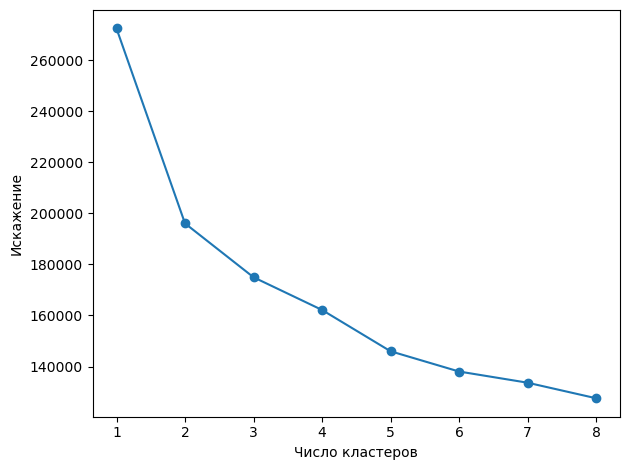

In [ ]:
distortion = []
for i in range(1, 9):
    km = KMeans(n_clusters=i, init='k-means++', n_init=8, max_iter=300, random_state=0)
    km.fit(sample_data_x)
    distortion.append(km.inertia_)
plt.plot(range(1, 9), distortion, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Искажение')
plt.tight_layout()
plt.show()

Есть локоть при K=4

0.2363149874351921


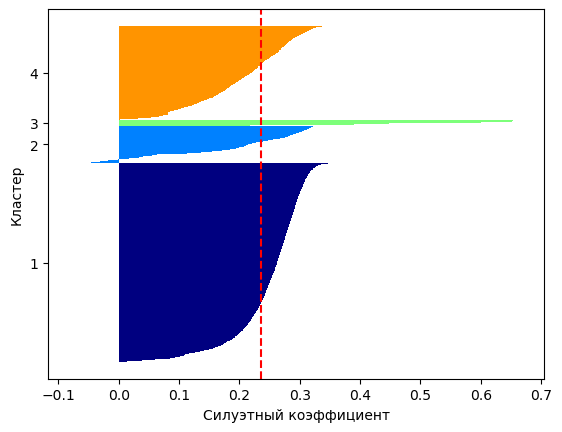

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = np.unique(y_kmeans_sample)
n_clusters = cluster_labels.shape[0]
silhoutte_vals = silhouette_samples(sample_data_x, y_kmeans_sample, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhoutte_vals[y_kmeans_sample == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = plt.cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhoutte_avg = np.mean(silhoutte_vals)
print(silhoutte_avg)
plt.axvline(silhoutte_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Кластер')
plt.xlabel('Силуэтный коэффициент')
plt.show()

Все кластэрные силуэты привышают среднее значение, что говорит о хорошем соответствии кластерной структуры исходным данным

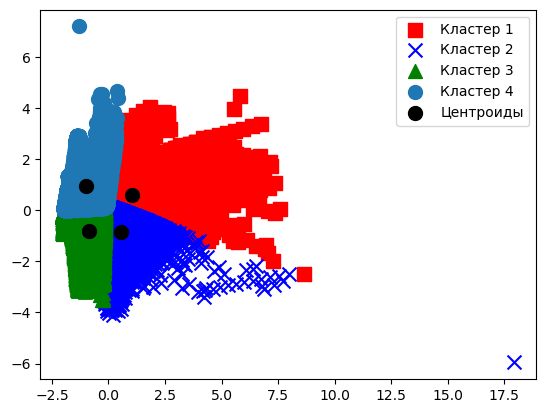

In [ ]:
kmeans = KMeans(n_clusters=4,init='k-means++',n_init=10,max_iter=300,random_state=0)
y_kmeans = kmeans.fit_predict(z_std)

plt.scatter(z_std[y_kmeans == 0, 0], z_std[y_kmeans == 0, 1], s=100, c='red', marker='s', label='Кластер 1')
plt.scatter(z_std[y_kmeans == 1, 0], z_std[y_kmeans == 1, 1], s=100, c='blue', marker='x', label='Кластер 2')
plt.scatter(z_std[y_kmeans == 2, 0], z_std[y_kmeans == 2, 1], s=100, c='green', marker='^', label='Кластер 3')
plt.scatter(z_std[y_kmeans == 3, 0], z_std[y_kmeans == 3, 1], s=100, marker='o', label='Кластер 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Центроиды')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
homogeneity = metrics.homogeneity_score(y, y_kmeans)
completeness = metrics.completeness_score(y, y_kmeans)
rand_index = metrics.rand_score(y, y_kmeans)
silhouette = metrics.silhouette_score(sample_data_x, y_kmeans_sample)
print('однородность:', homogeneity)
print('полнота:', completeness)
print('Индекс rand:', rand_index)
print('Силуэтный индекс:', silhouette)


однородность: 0.5272276724675142
полнота: 0.26454239061796625
Индекс rand: 0.6521509548530618
Силуэтный индекс: 0.2363149874351921


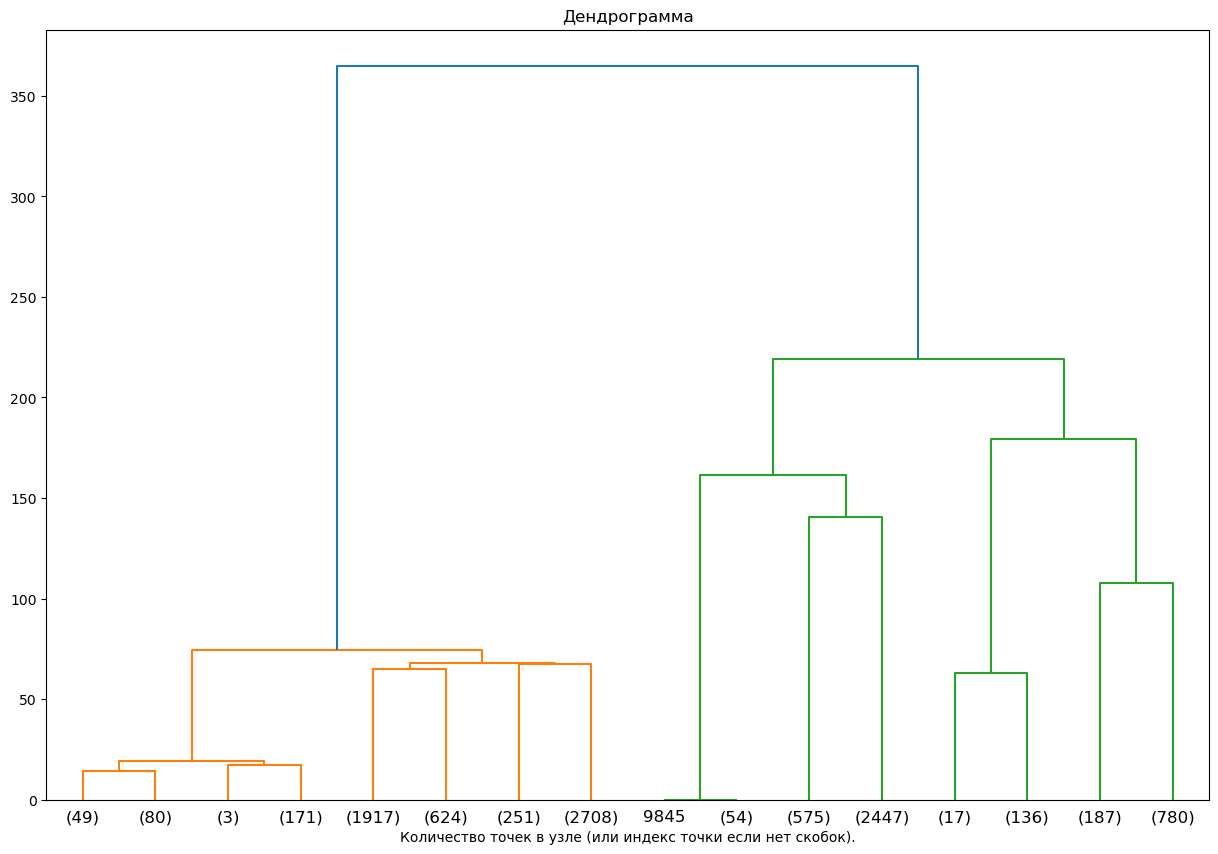

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram (model, **kwargs):
    counts = np.zeros(model.children_.shape [0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean')
model = model.fit(sample_data_x)
predicted_labels = model.labels_
plt.figure(figsize=(15, 10))
plt.title('Дендрограмма')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel('Количество точек в узле (или индекс точки если нет скобок).')
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=3)
model.fit(sample_data)
predicted_labels = model.labels_

homogeneity = metrics.homogeneity_score(sample_data_y, predicted_labels)
completeness = metrics.completeness_score(sample_data_y, predicted_labels)
rand_index = metrics.rand_score(sample_data_y, predicted_labels)
silhouette = metrics.silhouette_score(sample_data_x, predicted_labels)
print('однородность:', homogeneity)
print('полнота:', completeness)
print('Индекс rand:', rand_index)
print('Силуэтный индекс:', silhouette)

однородность: 0.359906050811649
полнота: 0.23544073005475225
Индекс rand: 0.6737938593859386
Силуэтный индекс: 0.12022416390785641


In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(sample_data_x)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 14
Estimated number of noise points: 9418


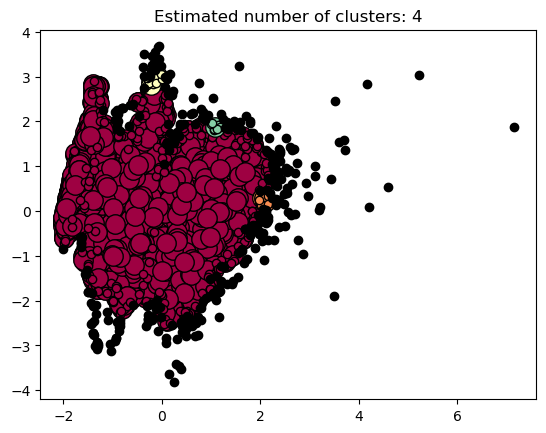

In [ ]:
sample_data_np = sample_data.to_numpy()  # Convert sample_data to a numpy array


db = DBSCAN(eps=0.12, min_samples=9).fit(sample_data)
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = sample_data_np[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = sample_data_np[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
db = DBSCAN(eps=0.1, min_samples=7).fit(sample_data_x)
labels = db.labels_

homogeneity = metrics.homogeneity_score(sample_data_y, labels)
completeness = metrics.completeness_score(sample_data_y, labels)
rand_index = metrics.rand_score(sample_data_y, labels)
silhouette = metrics.silhouette_score(sample_data_x, labels)
print('однородность:', homogeneity)
print('полнота:', completeness)
print('Индекс rand:', rand_index)
print('Силуэтный индекс:', silhouette)

однородность: 0.037839587912373185
полнота: 0.10759017350093326
Индекс rand: 0.5023532553255325
Силуэтный индекс: 0.0726310248604724


Вывод:
    Лучше всего показал себя кластеризация с алгоритмом K-Means. Алгоритмы кластеризации плохо подходят для этого набора данных.

1. Перечислите алгоритмы кластеризации на основе плотности.
Алгоритмы кластеризации на основе плотности включают в себя:

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
OPTICS (Ordering Points To Identify the Clustering Structure)
HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

2. Как определяется понятие плотности в алгоритме DBSCAN?

Плотность в этом алгоритме определяется количеством точек, а также расстоянием, на котором эти точки находятся.

3. Какие алгоритмы кластеризации рекомендуется использовать для данных содержащих выбросы и имеющих неплоскую геометрию? Поясните ответ.

Для данных, содержащих выбросы и имеющих неплоскую геометрию, рекомендуется использовать алгоритмы на основе плотности, такие как DBSCAN или HDBSCAN. Эти алгоритмы способны обрабатывать шумовые точки как выбросы, не требуя заранее заданного числа кластеров. Они также способны выявлять кластеры с неправильной формой или плотности.

4. Перечислите виды связи, используемые для стратегии слияния при иерархической кластеризации.

В иерархической кластеризации используются следующие виды связи для стратегии слияния:

Полное слияние (complete linkage): минимальное расстояние между всеми парами точек из двух кластеров.
Одиночное слияние (single linkage): минимальное расстояние между ближайшими точками из двух кластеров.
Среднее слияние (average linkage): среднее расстояние между всеми парами точек из двух кластеров.
Центроидное слияние (centroid linkage): расстояние между центроидами двух кластеров.

5. Как оценить производительность алгоритма кластеризации?

Производительность алгоритма кластеризации можно оценить с помощью различных метрик, таких как индекс силуэта, коэффициент Дэвиса-Болдина или внутрикластерное расстояние. Также можно использовать визуализацию результатов для наглядного понимания качества кластеризации.

6. Какие недостатки применения коэффициента силуэта при оценке качества кластеризации Вы знаете?

Недостатки применения коэффициента силуэта при оценке качества кластеризации включают:
Не всегда является информативным, особенно если кластеры имеют сложные формы или различные плотности.
Не учитывает структуру данных, такие как иерархическую или иные нестандартные связи между кластерами.
Чувствителен к выбору метрики расстояния и количеству кластеров.
Может давать завышенную оценку, если данные содержат шум или выбросы.




